# Assignment 2

The purpose of this assignment is to test your understanding of Classification.  You will use the Titanic dataset and your goal is to predict whether a passenger Survives based on the passenger's features.


# Instructions

## General

1. Use the same train  dataset as was used in the lecture.  Instructions below for where to find them.

2. As usual: your grade depends on **both** the correct answer and properly presenting your process (as in the "Recipe" taught in class, and the Geron book Appendix B)

3. You will classify whether a passenger Survives or not using Logistic Regression.

4. You may use the code presented in class to **start** your assignment but I expect you to significantly enhance it.  For example: you may use my code to get you started with plotting but it is up to you to decide whether this alone suffices.

5. Use 5-fold cross validation for all models.  Report the average as your result.


## Specific goals to address

1. Use a baseline model against which you will compare your models.
    - Discuss your choice.  Is this the best baseline model to use ?
    - Create a variable SCORE_BASELINE that contains a Python scalar value: the accuracy for your baseline model.
2. You will conduct several experiments 
    - present a Confusion Matrix for each experiment and discuss
    - you will create several variables per experiment that will be used for grading.
        - The variables for experiment 1 will have suffix "_1". For experiment 2, they will have suffix "_2", etc.
3. Experiment 1
    - You will *extend* the results presented in the lecture
        - use the same features
        - use the same way of dealing with missing features
        - be sure to treat categorical features correctly
     
    - Create a variable SCORE_1 that contains a Python scalar value: the accuracy for your experiment.
    - Create a variable MISCLASSIFIED_SURVIVE_1 that contains a Python list of *at least 10* passengers
        - the list should contain the identity of passengers that were mis-classified as Surviving.
        - the "identity" of a passenger should be given as the  *row number* within the unshuffled **train** data set,
        - The first row is considered row 0
    - Create a variable MISCLASSIFIED_NOT_SURVIVE_1 that contains a Python list of *at least 10* passengers
        - the list should contain the "identity" of passengers that were mis-classified as Not Surviving.
        - The "identity" of a passenger should be given as the  *row number* within the unshuffled **train** data set, as above
4. Experiment 2
    - Turn Age from a continous variable to one that is assigned to buckets.
        - You will decide the range for each bucket.  Discuss your choice
        - Treat the buckets as categorical features
    - Compare your prediction to the previous experiment and discuss
    - Create variables SCORE_2, MISCLASSIFIED_SURVIVE_2, MISCLASSIFIED_NOT_SURVIVE_2 analagous to the variables in Experiment 1
        
The correctness part of your grade will depend on the values you assign to these variables.    

# Extra credit

Create your own Logistic Regression model for the Titanic dataset given !
- Feel free to change **anything**, e.g., features or ways to treat missing values
- We will create a hidden test dataset
- Students whose model accuracy (evaluated on the hidden test dataset) are in the Top 33% of the class get extra credit !


# Getting the data 
You may obtain the train and test datasets from the repository using code from the following cell.

**NOTE** You may need to change the NOTEBOOK_ROOT variable to point to the directory into which you've cloned the repository.  On my machine, it is `~/Notebooks/NYU`.

In [4]:
import pandas as pd
import os

## NOTEBOOK_ROOT = "~/Notebooks/NYU"
NOTEBOOK_ROOT = "~/Desktop/7773 Machine Learning/ML_Spring_2019"
TITANIC_PATH = os.path.join( NOTEBOOK_ROOT, "external/jack-dies", "data")

train_data = pd.read_csv( os.path.join(TITANIC_PATH, "train.csv") )
test_data  = pd.read_csv( os.path.join(TITANIC_PATH, "test.csv")  )

In [5]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
import numpy as np
import random
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import FeatureUnion

# Experiement 1

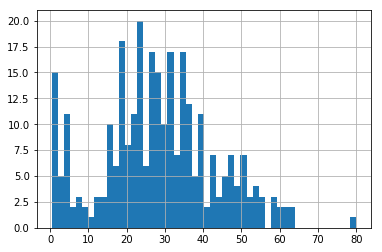

In [19]:
train_data[train_data["Survived"] == 1]["Age"].hist(bins=50)

In [34]:
train_data[(train_data["Sex"] == "female")].groupby("Pclass")["Survived"].mean()

Pclass
1    0.968085
2    0.921053
3    0.500000
Name: Survived, dtype: float64

In [35]:
train_data[(train_data["Sex"] == "male")].groupby("Pclass")["Survived"].mean()

Pclass
1    0.368852
2    0.157407
3    0.135447
Name: Survived, dtype: float64

In [40]:
imputer = SimpleImputer(strategy="most_frequent")

array([[1, 0, 3, ..., 7.25, 'B96 B98', 'S'],
       [2, 1, 1, ..., 71.2833, 'C85', 'C'],
       [3, 1, 3, ..., 7.925, 'B96 B98', 'S'],
       ...,
       [889, 0, 3, ..., 23.45, 'B96 B98', 'S'],
       [890, 1, 1, ..., 30.0, 'C148', 'C'],
       [891, 0, 3, ..., 7.75, 'B96 B98', 'Q']], dtype=object)

In [70]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
PclassSex      891 non-null object
FamilySize     891 non-null int64
dtypes: float64(2), int64(6), object(6)
memory usage: 97.5+ KB


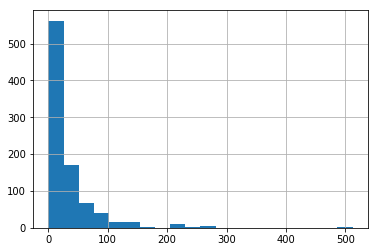

In [74]:
train_data["Fare"].hist(bins=20)

In [66]:
train_data["PclassSex"] = train_data["Pclass"].apply(str) + train_data["Sex"]

In [68]:
train_data["FamilySize"] = train_data["SibSp"] + train_data["Parch"] + 1

In [69]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,PclassSex,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,3male,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1female,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,3female,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1female,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,3male,1


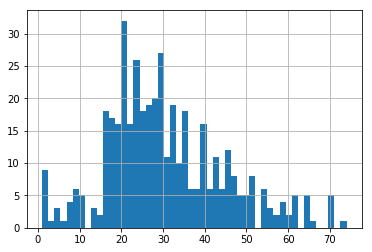

In [44]:
train_data[train_data["Survived"] == 0]["Age"].hist(bins=50)

In [134]:
# Plot the histograms of the Age of the Survived and the Not-Survived
# Judging from the histograms, we decide
# 0-10 is the first bucket
# 10-40 is the second bucket
# 40-60 is the third bucket
# above 60 is the fourth bucket


train_data["AgeBucket"] = np.nan

for i in range(len(train_data)):
    if train_data.loc[i, "Age"] < 10:
        train_data.loc[i, "AgeBucket"] = 0
    if 10 <= train_data.loc[i, "Age"] < 40:
        train_data.loc[i, "AgeBucket"] = 1
    if 40 <= train_data.loc[i, "Age"] < 60:
        train_data.loc[i, "AgeBucket"] = 2
    if train_data.loc[i, "Age"] >= 60:
        train_data.loc[i, "AgeBucket"] = 3

In [135]:
# Drop the data not possibly used in the training.
# PassengerId, Name, Ticket are not relevant.
# Cabin has too much missed values. It is unable to use it.
# Age is replaced for AgeBucket. Drop Age.

# X_train
titanic_train = train_data.drop(["PassengerId", "Survived", "Name", "Ticket", "Cabin", "Age"], axis=1)
# y_train
titanic_train_labels = train_data["Survived"].copy()

In [136]:
# seperate the data into two part: numerical and categorical

# numerical data of training set
titanic_train_num = titanic_train[["SibSp", "Parch", "Fare"]]
# categorical data of training set
# AgeBucket is categorical
titanic_train_cat = titanic_train[["Pclass", "Sex", "Embarked", "AgeBucket"]]

In [137]:
num_attribs = list(titanic_train_num)
cat_attribs = list(titanic_train_cat)

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs)
])

In [138]:
# training set transformed by all the pipeline(imputer, encoder, standard scaler)
titanic_train_prepared = full_pipeline.fit_transform(titanic_train)

In [139]:
logistic_clf = LogisticRegression(solver="liblinear")
logistic_clf.fit(titanic_train_prepared, titanic_train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [140]:
SCORE_2 = cross_val_score(logistic_clf, titanic_train_prepared, titanic_train_labels, cv=5, scoring="accuracy")
SCORE_2 =  SCORE_2.mean()
print("Score of Experiment 2: {s}".format(s=SCORE_2))

Score of Experiment 2: 0.8047307828570031


In [141]:
titanic_train_predict = logistic_clf.predict(titanic_train_prepared)

In [142]:
titanic_train_confusion_matrix = confusion_matrix(titanic_train_labels, titanic_train_predict)

In [143]:
CONFUSION_MATRIX_2 = pd.DataFrame(titanic_train_confusion_matrix, 
                                  columns=["Predicted Negative", "Predicted Positive"],
                                  index=["Actual Negative", "Actual Positive"])
print("Confusion Matrix of Experiment 2: \n")
print(CONFUSION_MATRIX_2)

Confusion Matrix of Experiment 2: 

                 Predicted Negative  Predicted Positive
Actual Negative                 479                  70
Actual Positive                  96                 246


In [144]:
titanic_subtract = titanic_train_predict - titanic_train_labels
# 1 suggests that (survive) - (not survive) = misclassified survive
# -1 suggests that (not survive) - (survive) = misclassified not survive

MISCLASSIFIED_SURVIVE_2 = list(titanic_subtract[titanic_subtract == 1].index)
MISCLASSIFIED_NOT_SURVIVE_2 = list(titanic_subtract[titanic_subtract == -1].index)

In [145]:
print("Misclassified Survive Passengers: Total {p}\n".format(p=len(MISCLASSIFIED_SURVIVE_2)))
print(MISCLASSIFIED_SURVIVE_2, "\n")
print("Misclassified Not Survive Passengers: Total {p}\n".format(p=len(MISCLASSIFIED_NOT_SURVIVE_2)))
print(MISCLASSIFIED_NOT_SURVIVE_2, "\n")

Misclassified Survive Passengers: Total 70

[14, 18, 24, 41, 49, 64, 100, 111, 113, 114, 118, 119, 139, 140, 147, 177, 199, 205, 235, 240, 246, 264, 276, 293, 295, 297, 312, 357, 362, 373, 374, 377, 396, 402, 404, 415, 419, 452, 474, 498, 501, 502, 503, 505, 527, 534, 541, 557, 564, 578, 583, 593, 617, 634, 642, 654, 657, 680, 702, 729, 766, 767, 772, 793, 807, 813, 816, 852, 854, 882] 

Misclassified Not Survive Passengers: Total 96

[17, 21, 23, 25, 36, 55, 65, 68, 74, 81, 85, 107, 125, 127, 146, 165, 183, 187, 204, 207, 209, 220, 224, 226, 248, 261, 267, 271, 279, 283, 286, 288, 298, 301, 328, 338, 348, 370, 390, 391, 400, 414, 429, 430, 444, 447, 449, 453, 455, 460, 483, 484, 489, 507, 509, 510, 512, 543, 547, 553, 569, 570, 572, 579, 587, 599, 607, 621, 622, 630, 643, 645, 647, 660, 664, 673, 690, 692, 701, 707, 709, 712, 724, 740, 744, 751, 762, 788, 802, 803, 804, 821, 828, 838, 857, 869] 

